<a href="https://colab.research.google.com/github/LuBly/Knowledge_Distillation/blob/main/CNN_Layer2_BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import Library For Create CNN Layer model

In [24]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as torch_models
import torch.nn.functional as F
import torch.optim as optim

Import Library For Data Load

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms

Import Library For Training

In [45]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Import Library For display chart

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

CNN Layer model 생성

In [50]:
class ConvNetMaker(nn.Module):
	"""
	Creates a simple (plane) convolutional neural network
	"""
	def __init__(self, layers):
		"""
		Makes a cnn using the provided list of layers specification
		The details of this list is available in the paper
		:param layers: a list of strings, representing layers like ["CB32", "CB32", "FC10"]
		"""
		super(ConvNetMaker, self).__init__()
		self.conv_layers = []
		self.fc_layers = []
		h, w, d = 32, 32, 3
		previous_layer_filter_count = 3
		previous_layer_size = h * w * d
		num_fc_layers_remained = len([1 for l in layers if l.startswith('FC')])
		for layer in layers:
			if layer.startswith('Conv'):
				filter_count = int(layer[4:])
				self.conv_layers += [nn.Conv2d(previous_layer_filter_count, filter_count, kernel_size=3, padding=1),
									 nn.BatchNorm2d(filter_count), nn.ReLU(inplace=True)]
				previous_layer_filter_count = filter_count
				d = filter_count
				previous_layer_size = h * w * d
			elif layer.startswith('MaxPool'):
				self.conv_layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
				h, w = int(h / 2.0), int(w / 2.0)
				previous_layer_size = h * w * d
			elif layer.startswith('FC'):
				num_fc_layers_remained -= 1
				current_layer_size = int(layer[2:])
				if num_fc_layers_remained == 0:
					self.fc_layers += [nn.Linear(previous_layer_size, current_layer_size)]
				else:
					self.fc_layers += [nn.Linear(previous_layer_size, current_layer_size), nn.ReLU(inplace=True)]
				previous_layer_size = current_layer_size
		
		conv_layers = self.conv_layers
		fc_layers = self.fc_layers
		self.conv_layers = nn.Sequential(*conv_layers)
		self.fc_layers = nn.Sequential(*fc_layers)
	
	def forward(self, x):
		x = self.conv_layers(x)
		x = x.view(x.size(0), -1)
		x = self.fc_layers(x)
		return x



def plane2():
    return ConvNetMaker(['Conv16', 'MaxPool', 'Conv16', 'MaxPool', 'FC10'])

def plane10():
    return ConvNetMaker(['Conv32', 'Conv32', 'MaxPool', 'Conv64', 'Conv64', 'MaxPool', 'Conv128', 'Conv128', 'MaxPool',
		   'Conv256', 'Conv256', 'Conv256', 'Conv256' , 'MaxPool', 'FC128' ,'FC10'])

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = plane2().to(device)
x = torch.randn(3, 3, 32, 32).to(device)
output = model(x)
print(output.size())

torch.Size([3, 10])


In [29]:
summary(model, (3, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           2,320
       BatchNorm2d-6           [-1, 16, 16, 16]              32
              ReLU-7           [-1, 16, 16, 16]               0
         MaxPool2d-8             [-1, 16, 8, 8]               0
            Linear-9                   [-1, 10]          10,250
Total params: 13,082
Trainable params: 13,082
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.51
Params size (MB): 0.05
Estimated Total Size (MB): 0.57
---------------------------------------------

Data Load

In [56]:
dataset_dir='./data'
batch_size=128
normalize = transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
simple_transform = transforms.Compose([transforms.ToTensor(), normalize])

train_transform = simple_transform

trainset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True,
download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR10(root=dataset_dir, train=False,
download=True, transform=simple_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
pin_memory=True, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
pin_memory=True, shuffle=False)

  

print("CIFAR10")
print("---"*20)

Files already downloaded and verified
Files already downloaded and verified
CIFAR10
------------------------------------------------------------


모델 학습하기

In [57]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [59]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [60]:
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [61]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

In [62]:
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            # best_model_wts = copy.deepcopy(model.state_dict())

            # torch.save(model.state_dict(), path2weights)
            # print('Copied best model weights!')
            print('Get best val_loss')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [63]:
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'val_dl':testloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [46]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/19, current lr=0.01
Get best val_loss
train loss: 1.498200, val loss: 1.185413, accuracy: 58.35, time: 0.3029 min
----------
Epoch 1/19, current lr=0.01
Get best val_loss
train loss: 1.095840, val loss: 1.107080, accuracy: 62.00, time: 0.6074 min
----------
Epoch 2/19, current lr=0.01
Get best val_loss
train loss: 0.991575, val loss: 1.038464, accuracy: 64.28, time: 0.9311 min
----------
Epoch 3/19, current lr=0.01
Get best val_loss
train loss: 0.935766, val loss: 0.955689, accuracy: 67.25, time: 1.2493 min
----------
Epoch 4/19, current lr=0.01
train loss: 0.897222, val loss: 1.011021, accuracy: 65.44, time: 1.5556 min
----------
Epoch 5/19, current lr=0.01
Get best val_loss
train loss: 0.883942, val loss: 0.950106, accuracy: 67.43, time: 1.8720 min
----------
Epoch 6/19, current lr=0.01
Get best val_loss
train loss: 0.851674, val loss: 0.937271, accuracy: 67.59, time: 2.1895 min
----------
Epoch 7/19, current lr=0.01
Get best val_loss
train loss: 0.834403, val loss: 0.937151,

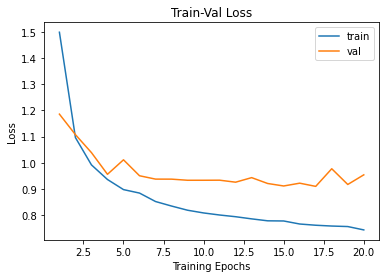

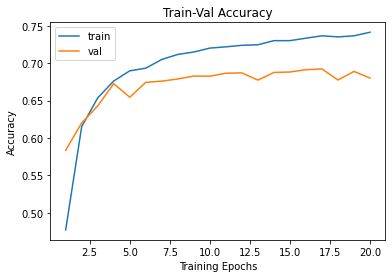

In [49]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()